# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'0.0.88'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files

['01 Ne--Spectrum--007--Spec.Data 1.txt',
 '02 Ne--Spectrum--008--Spec.Data 1.txt',
 '03 Ne--Spectrum--009--Spec.Data 1.txt',
 '07 Ne--Spectrum--014--Spec.Data 1.txt',
 '11 Ne--Spectrum--029--Spec.Data 1.txt',
 '18 Ne--Spectrum--044--Spec.Data 1.txt',
 '26 Ne--Spectrum--060--Spec.Data 1.txt',
 '30 Ne--Spectrum--070--Spec.Data 1.txt',
 '35 Ne--Spectrum--078--Spec.Data 1.txt',
 '37 Ne--Spectrum--083--Spec.Data 1.txt',
 '40 Ne--Spectrum--094--Spec.Data 1.txt',
 '46 Ne--Spectrum--103--Spec.Data 1.txt',
 '47 Ne--Spectrum--104--Spec.Data 1.txt',
 '49 Ne--Spectrum--106--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.head()

Raman_shift (cm-1)  Intensity  Ne emission line in air
3           391.536362     2500.0                543.36513
15          818.699523     5000.0                556.27662
23         1117.086987     5000.0                565.66588
30         1310.480205     5000.0                571.92248
33         1398.915133     5000.0                574.82985

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Line_1_int  Line_2_int  \
0  330.477634  1117.086987  1447.564622      5000.0      7000.0   

   Entered Pos Line 1  Entered Pos Line 2  
0                1117                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--Spectrum--007--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583   5129.333496  1447.663174       48856.0  4413.033478   

     Peak2_prom  
0  48139.699982

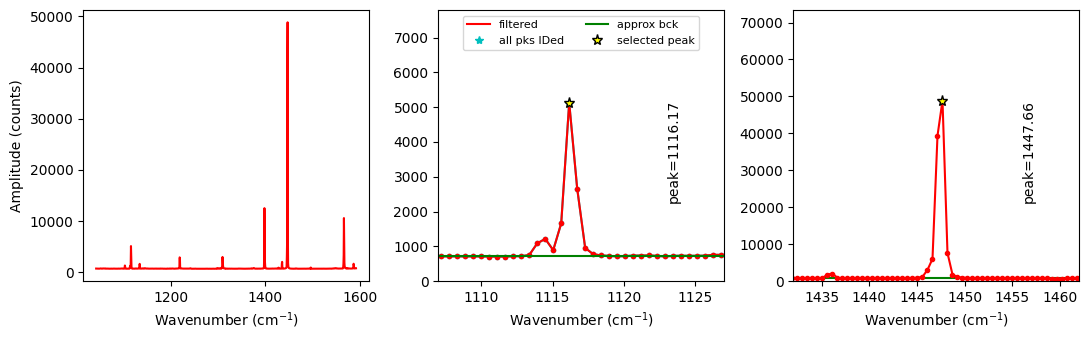

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  \
0  Ne--Spectrum--007--Spec.Data 1.txt         0.000039    0.000039   

   pk2_peak_cent  pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  \
0    1447.444625    57254.13875   0.382425      None   0.001584   

   Peak2_Prop_Lor  pk1_peak_cent  ...  Peak1_Prop_Lor     deltaNe   Ne_Corr  \
0        0.396948    1116.260329  ...        0.338376  331.184296  0.997866   

   Ne_Corr_min  Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  \
0     0.997823      0.99791    134.335243     12.140726        146.475969   

   error_pk1_amplitude  error_pk2_amplitude  
0           189.322305           427.794082  

[1 rows x 24 columns]

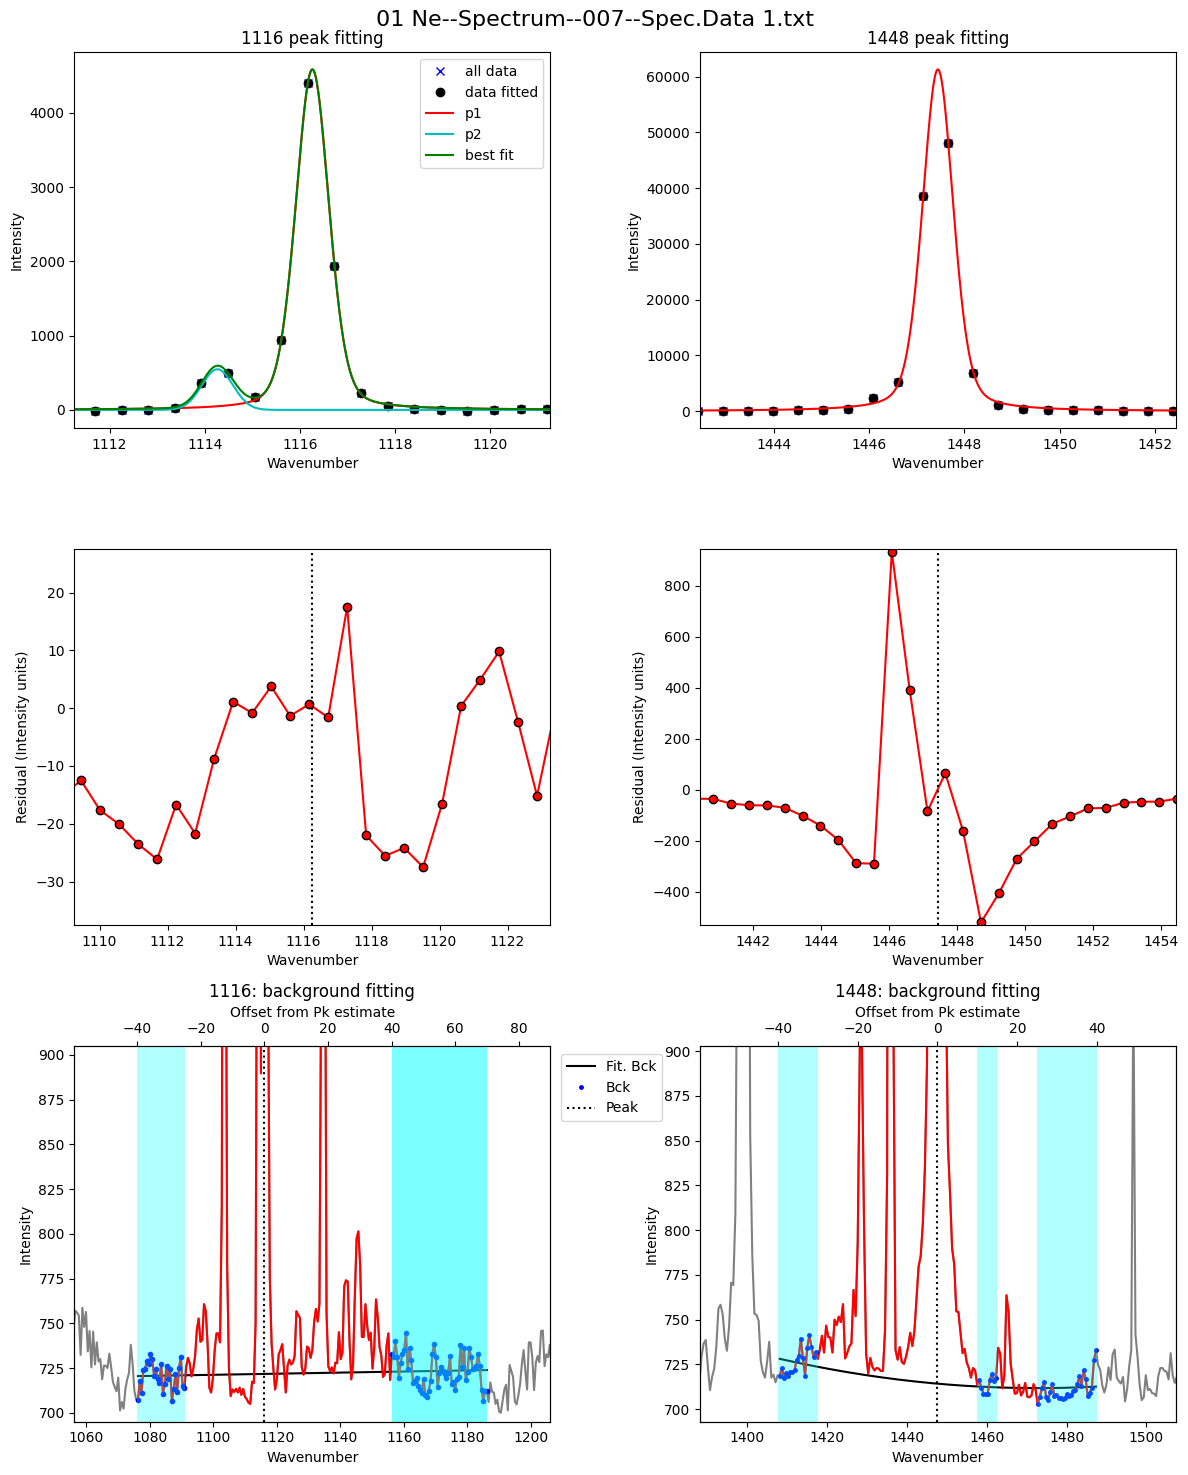

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/14 [00:00<?, ?it/s]

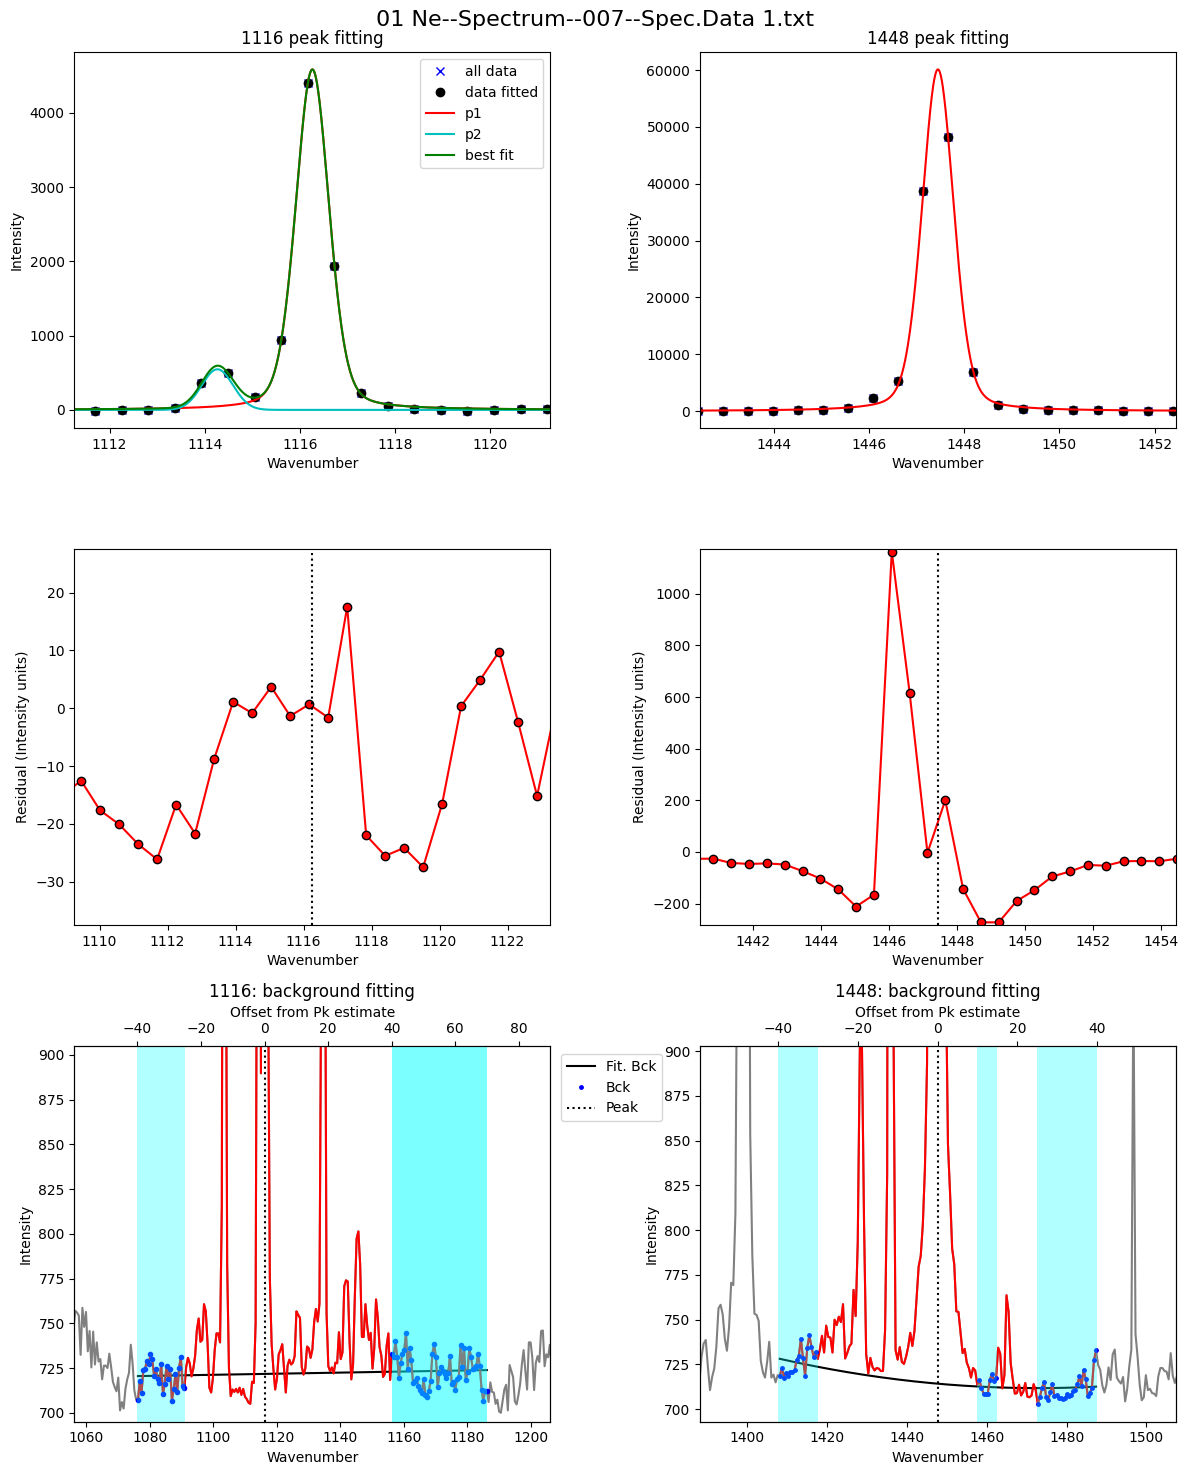

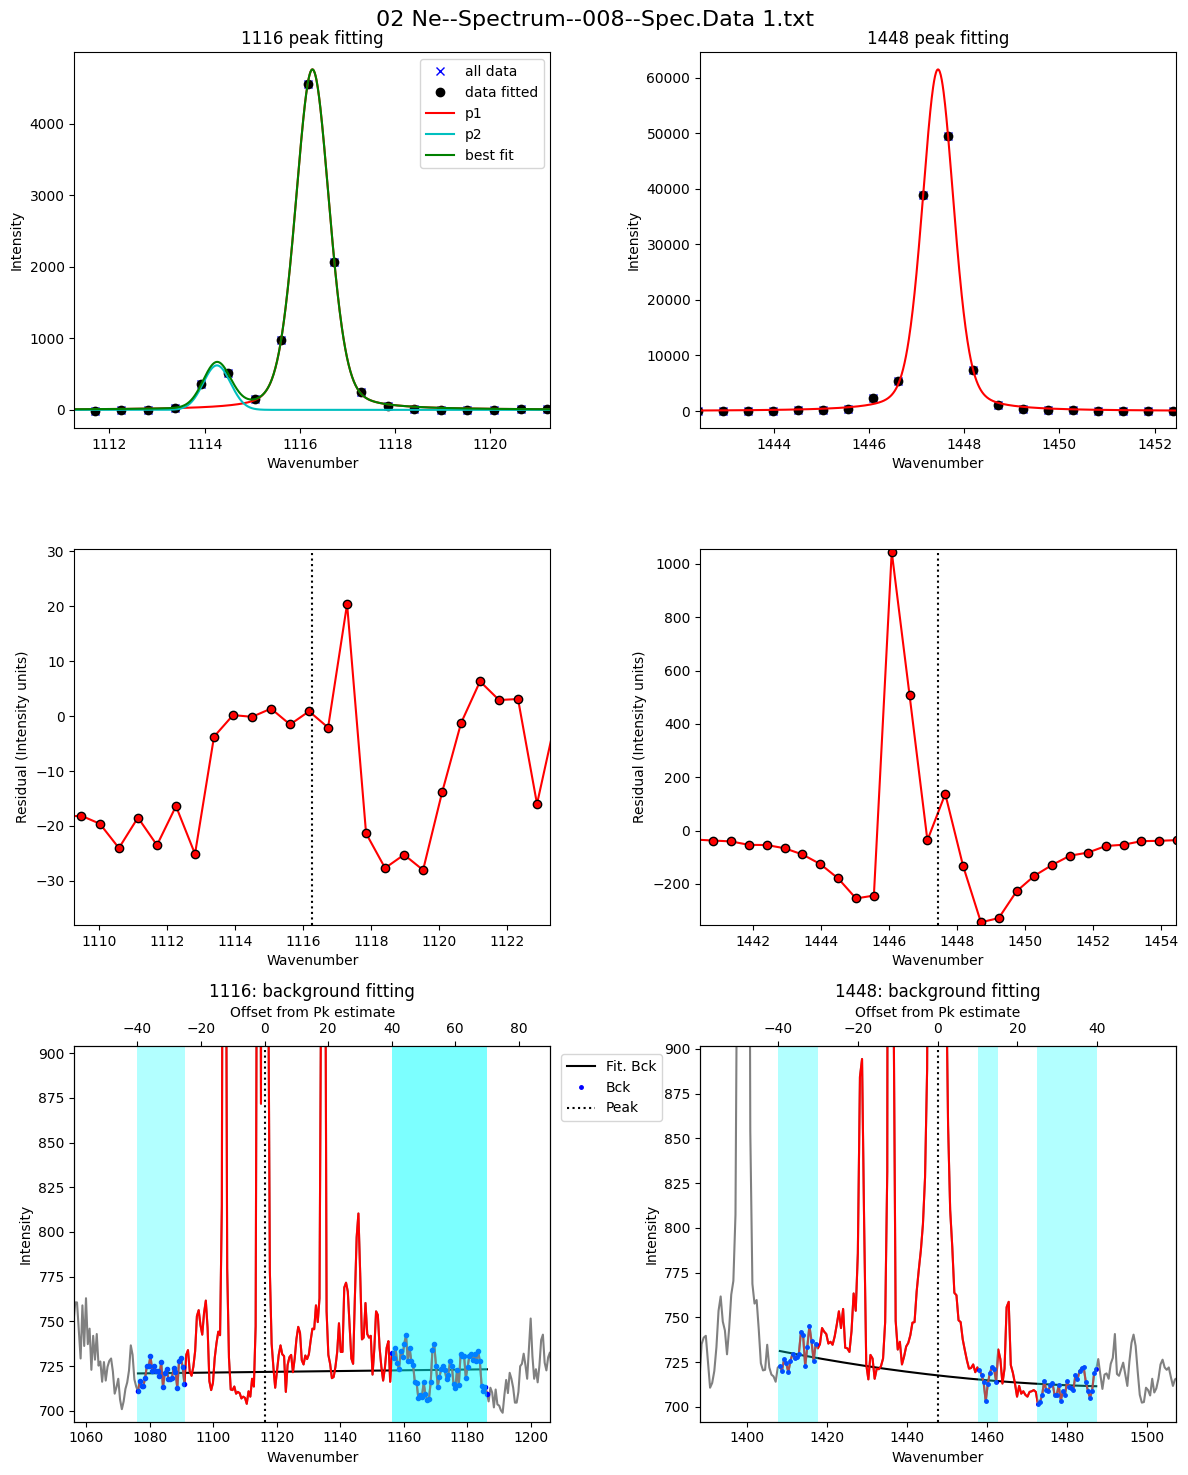

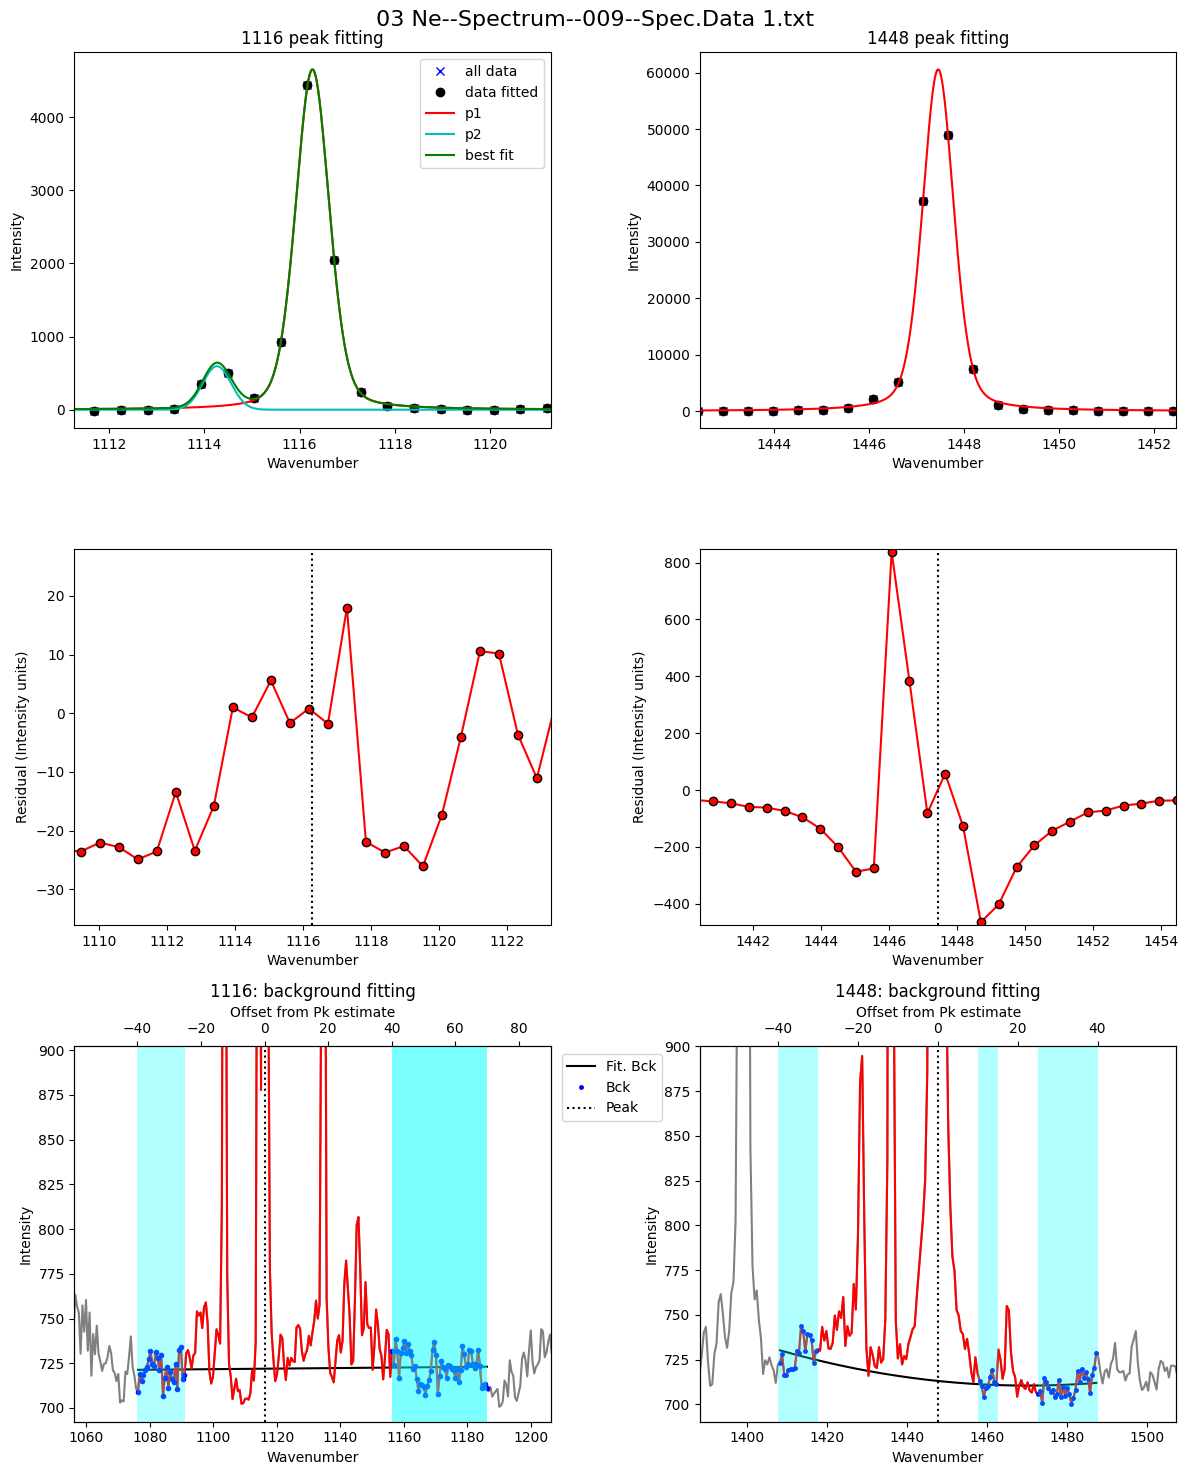

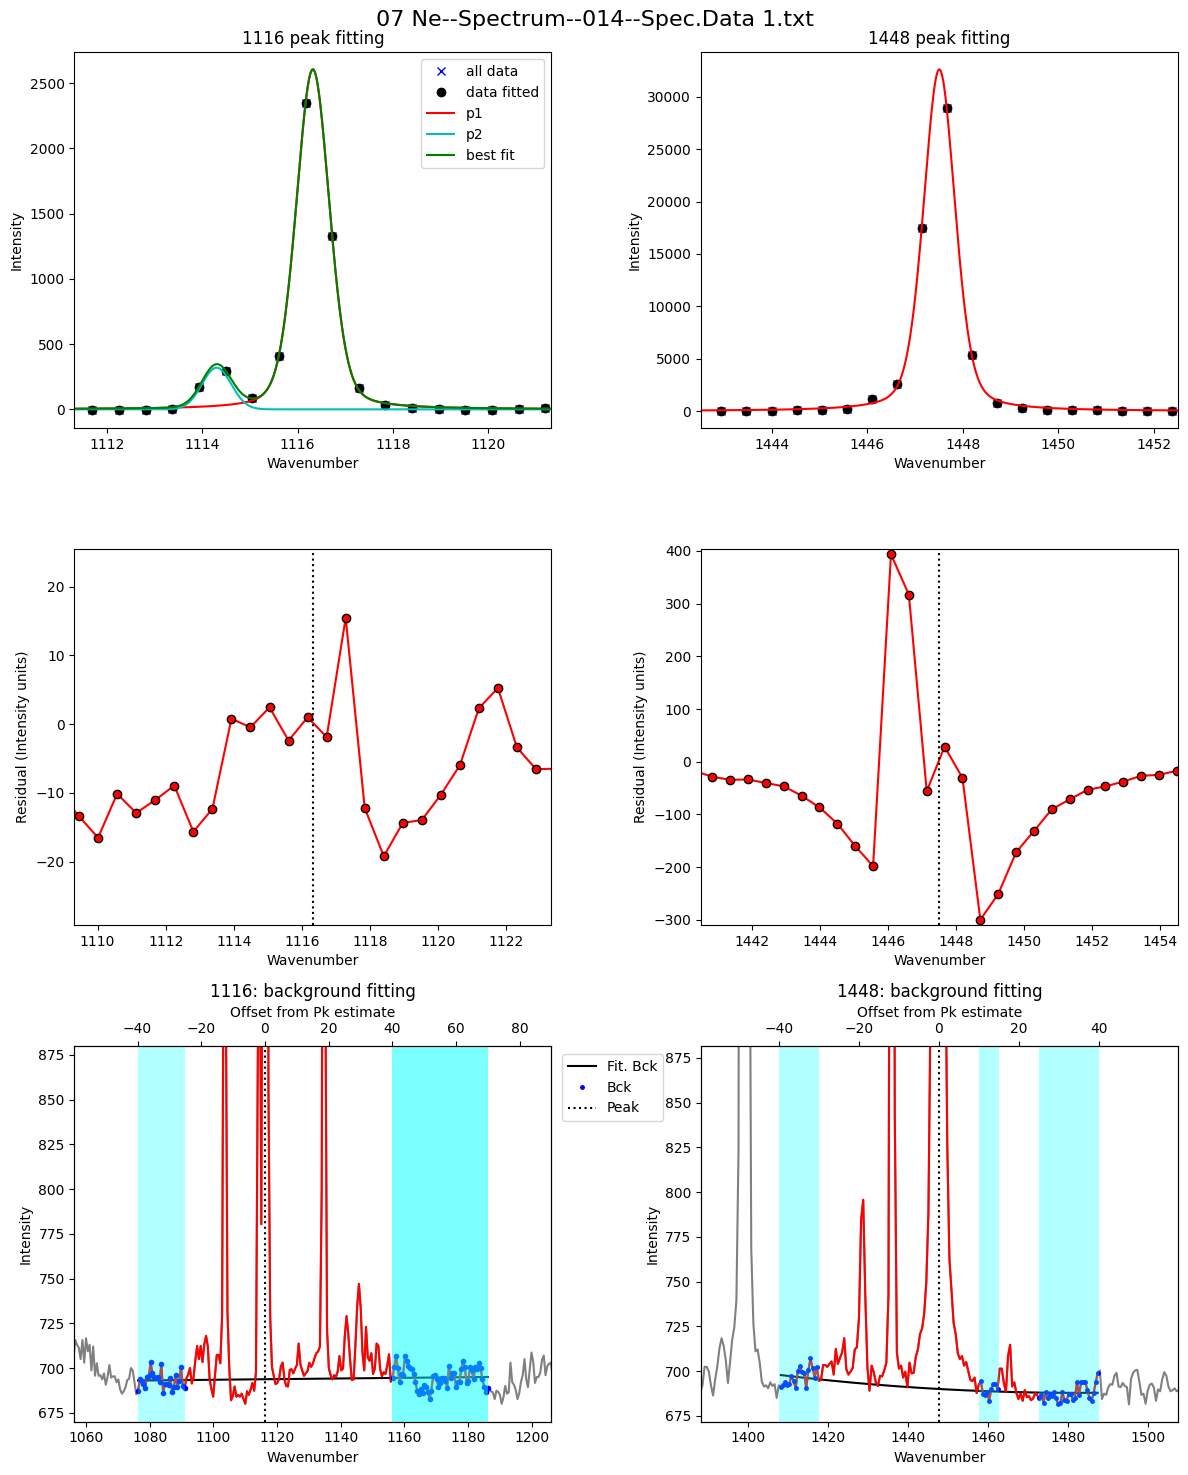

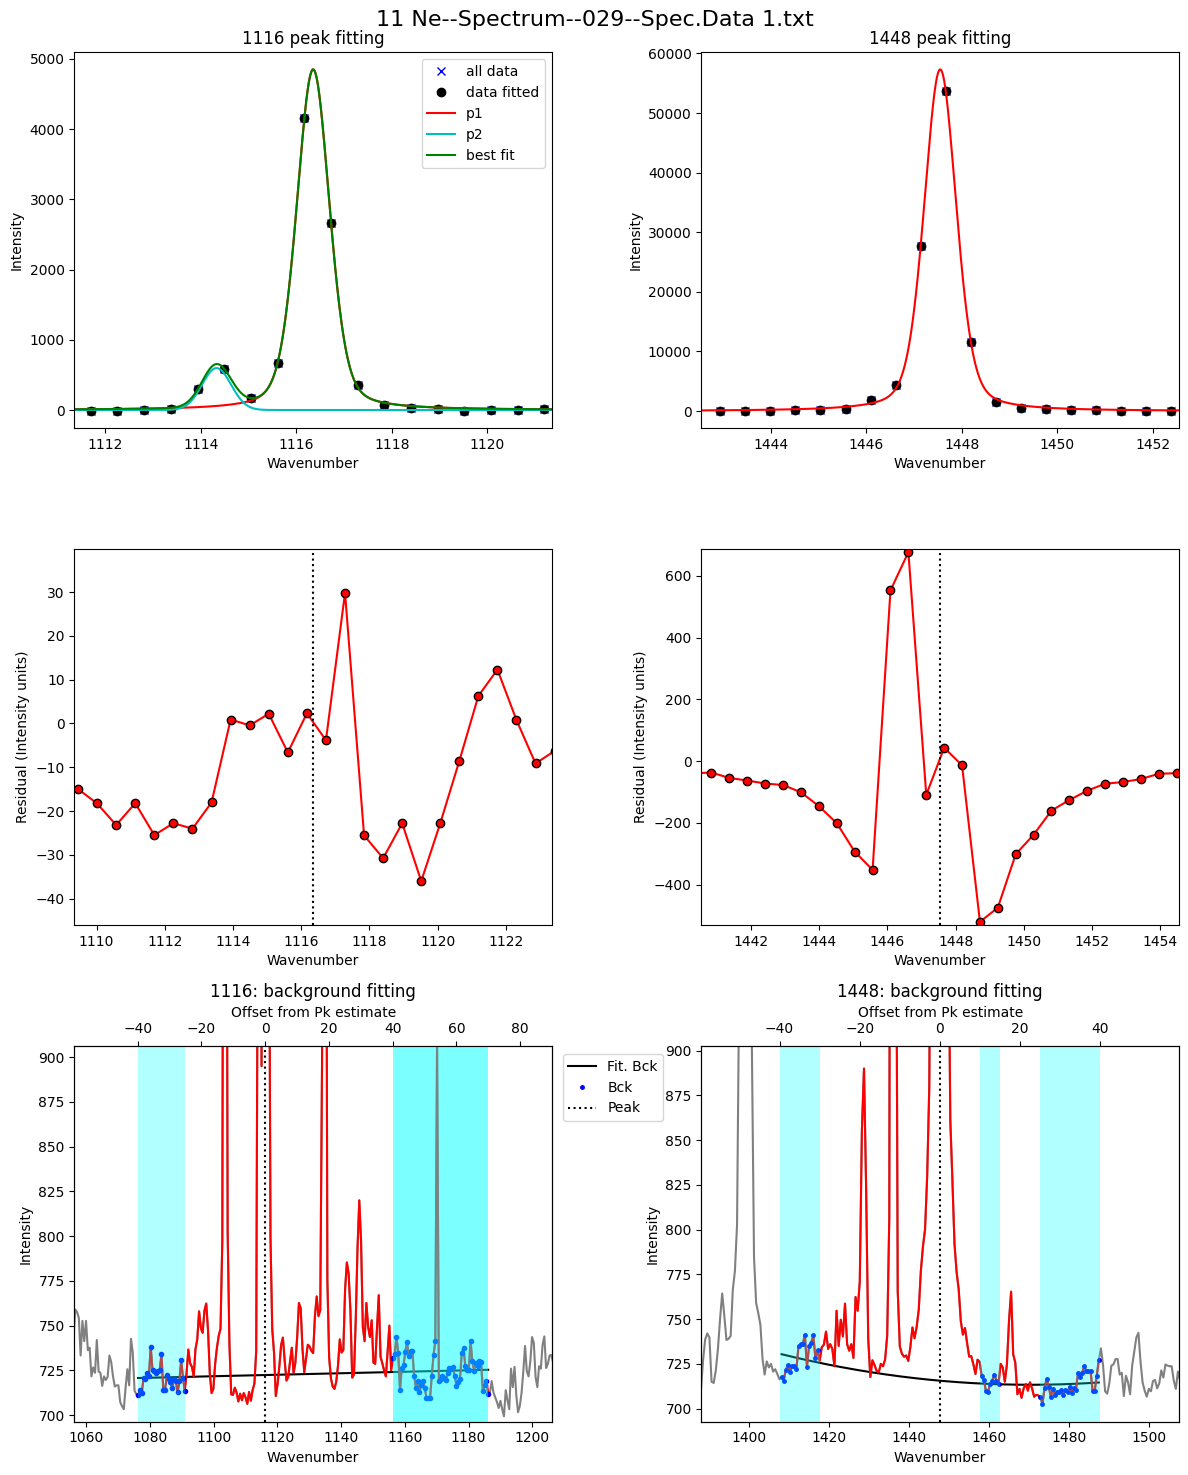

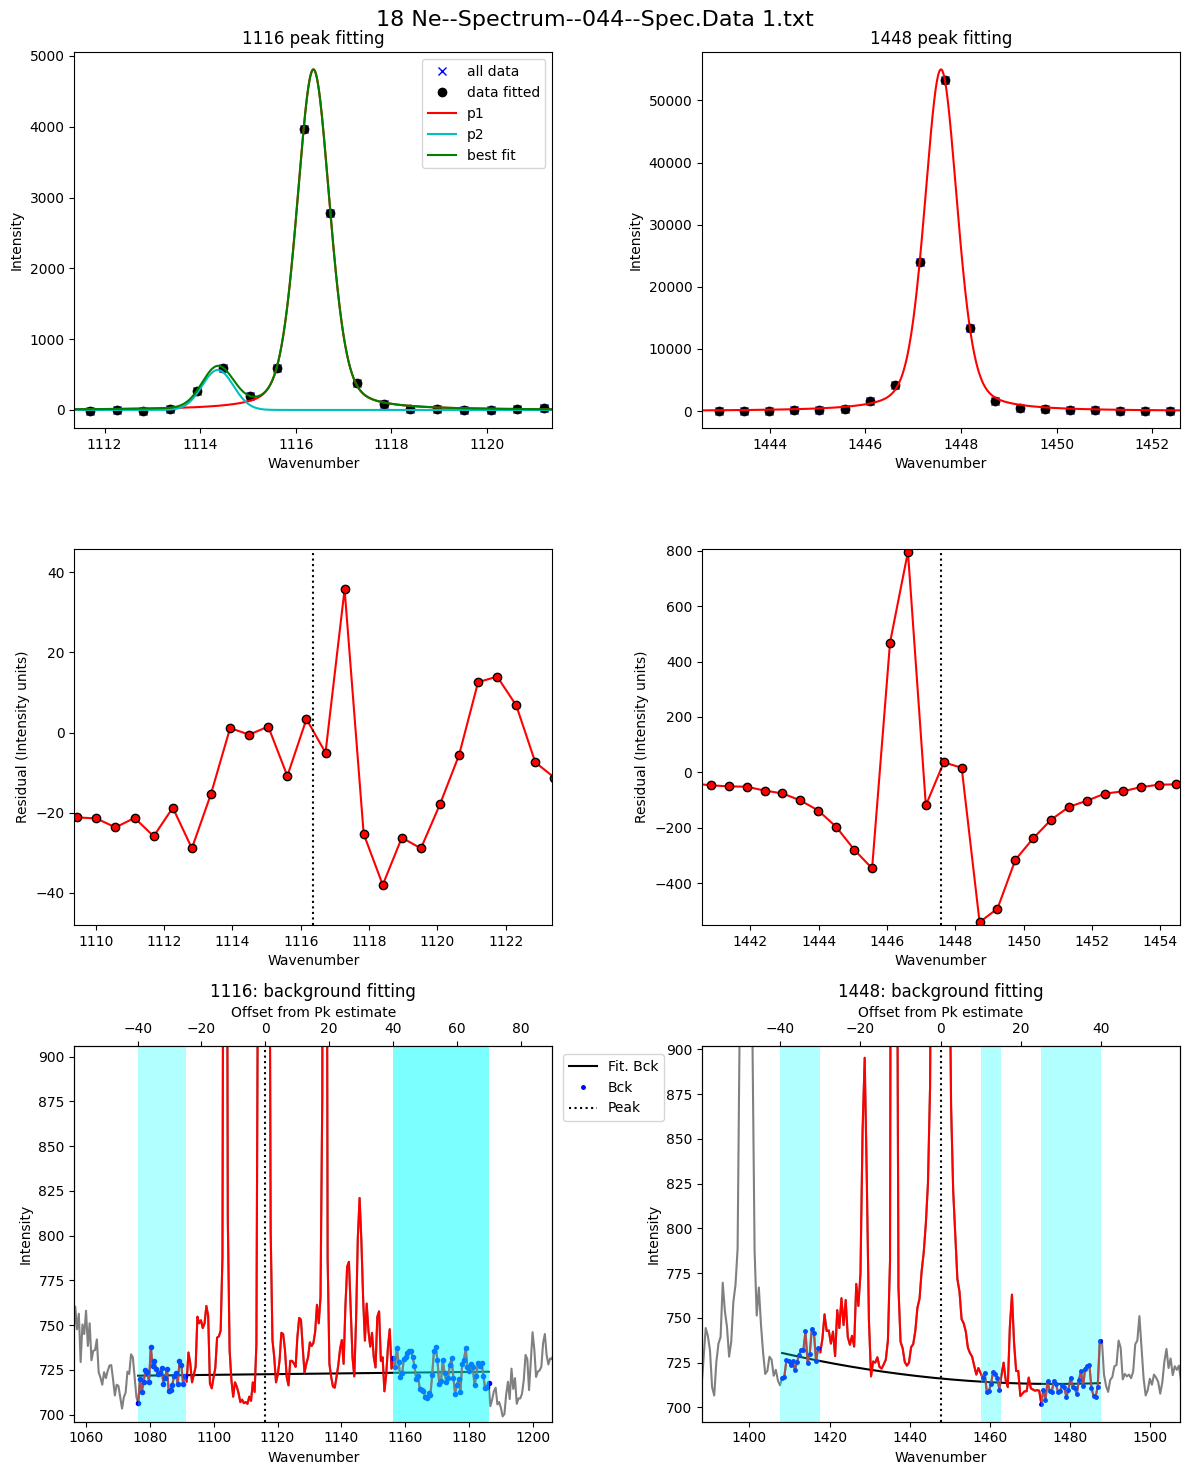

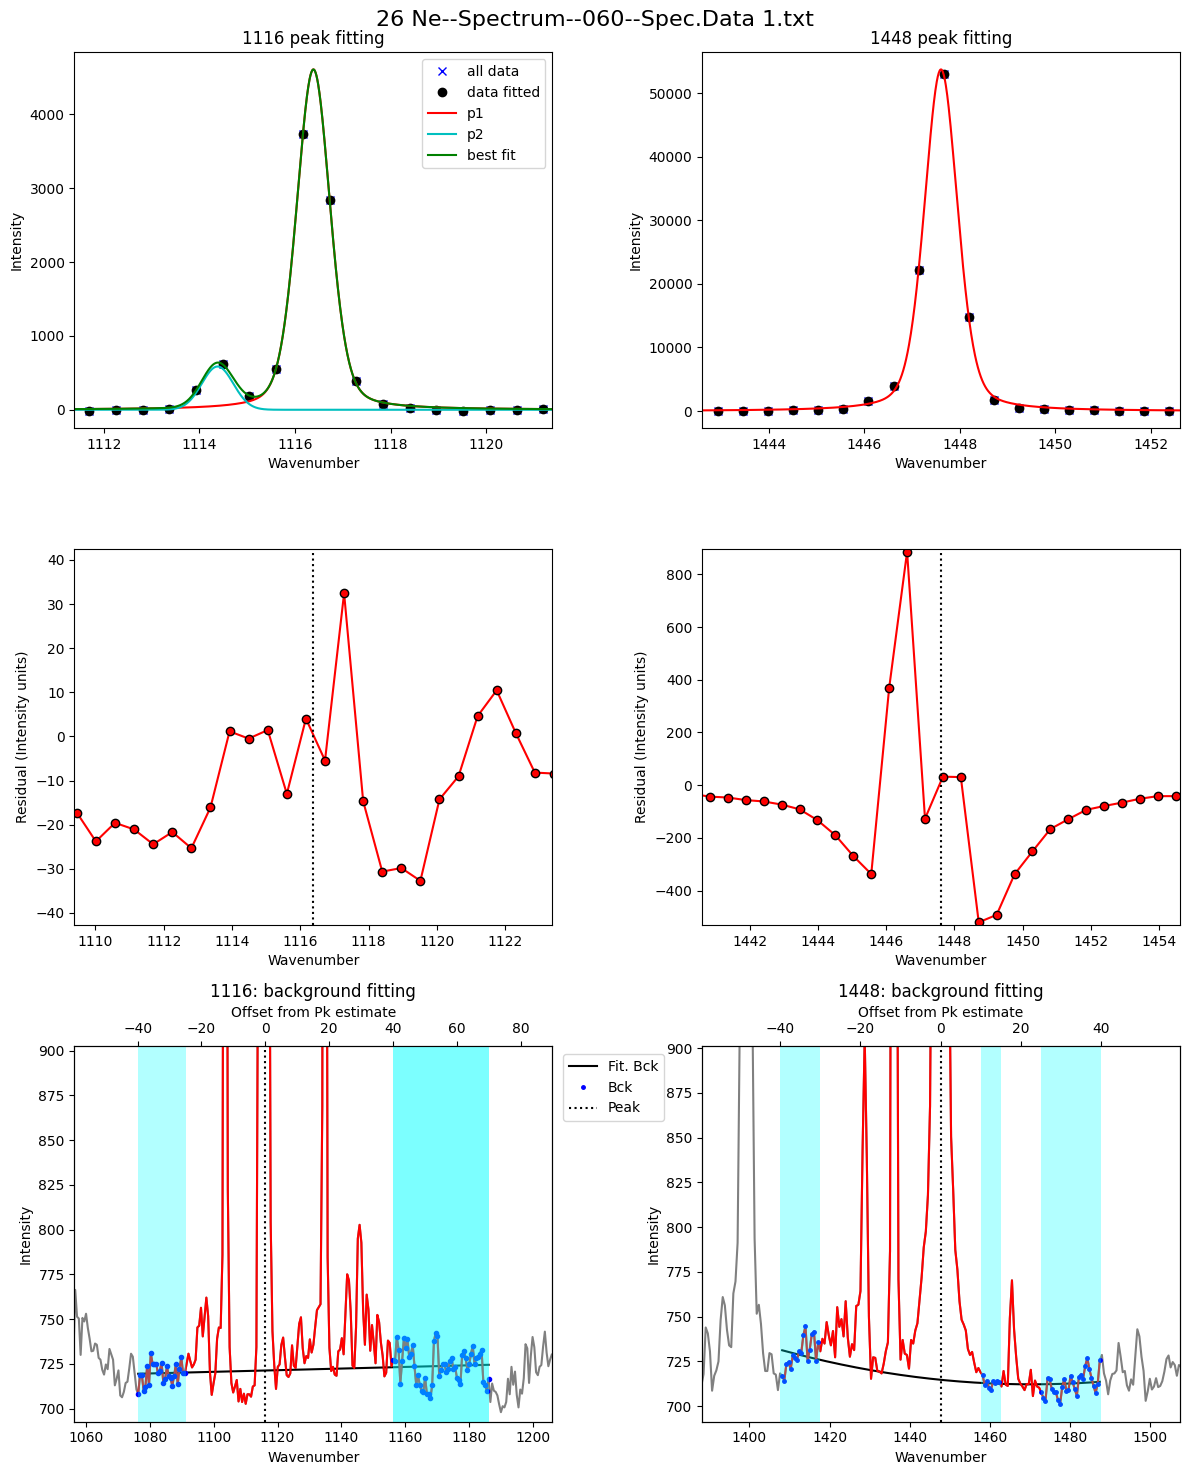

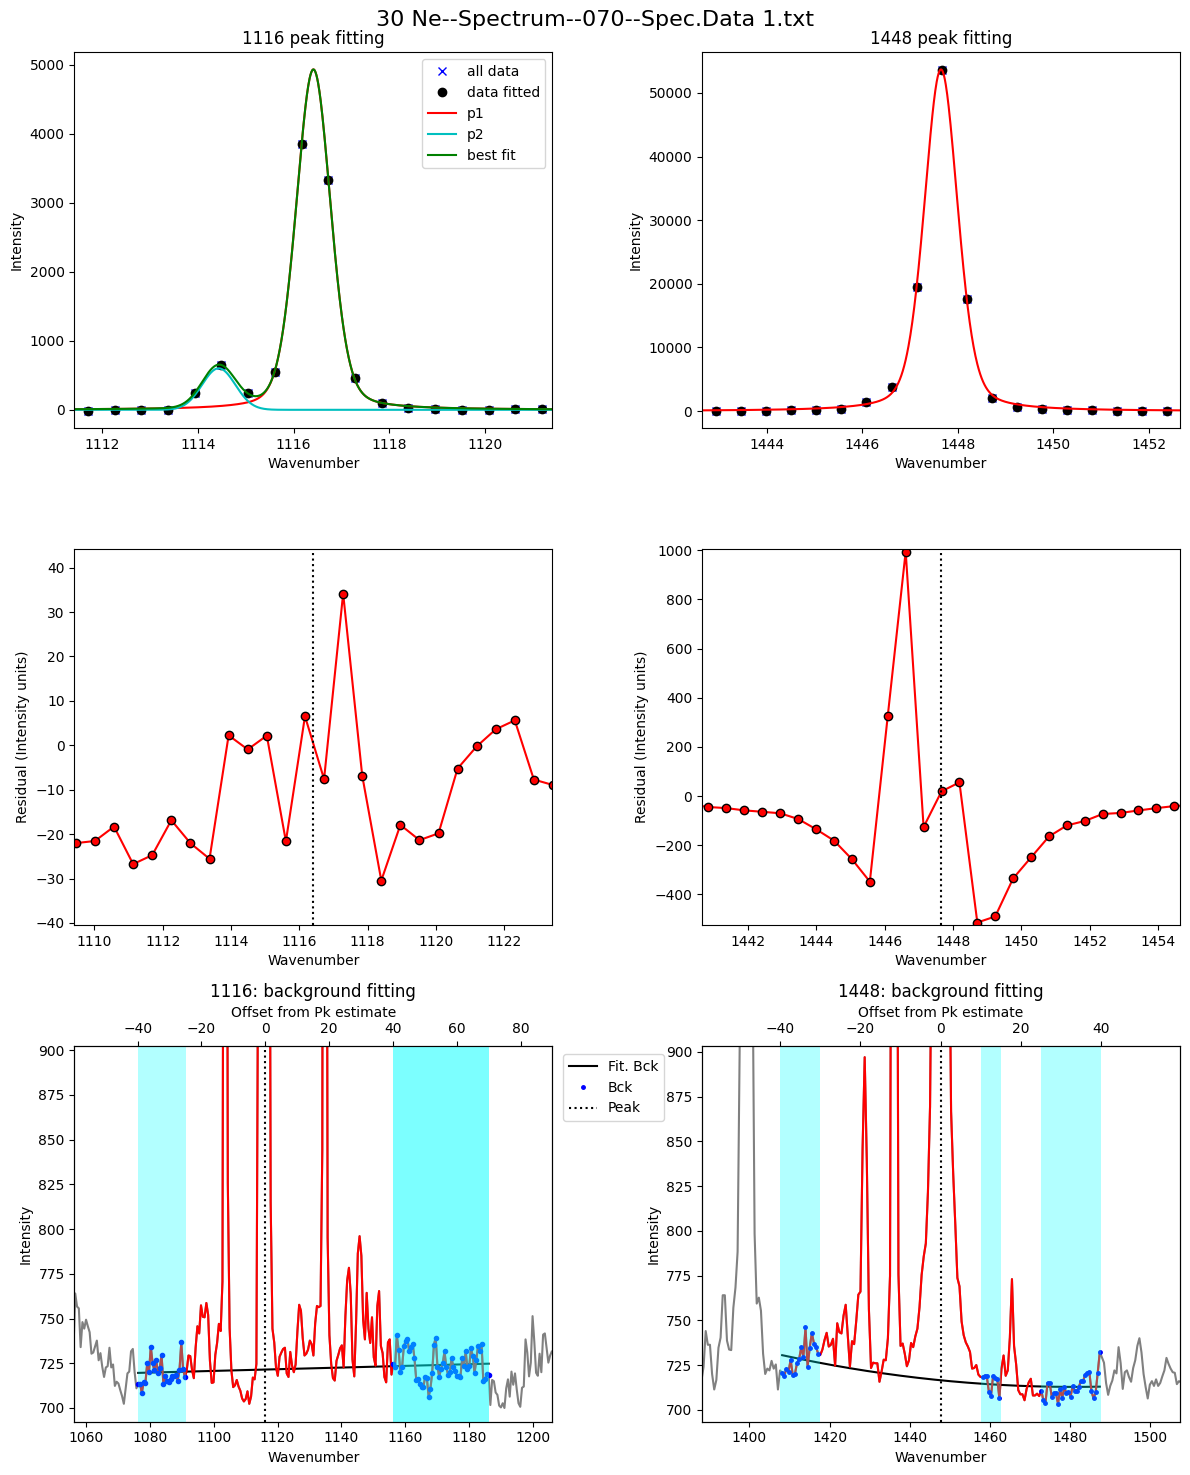

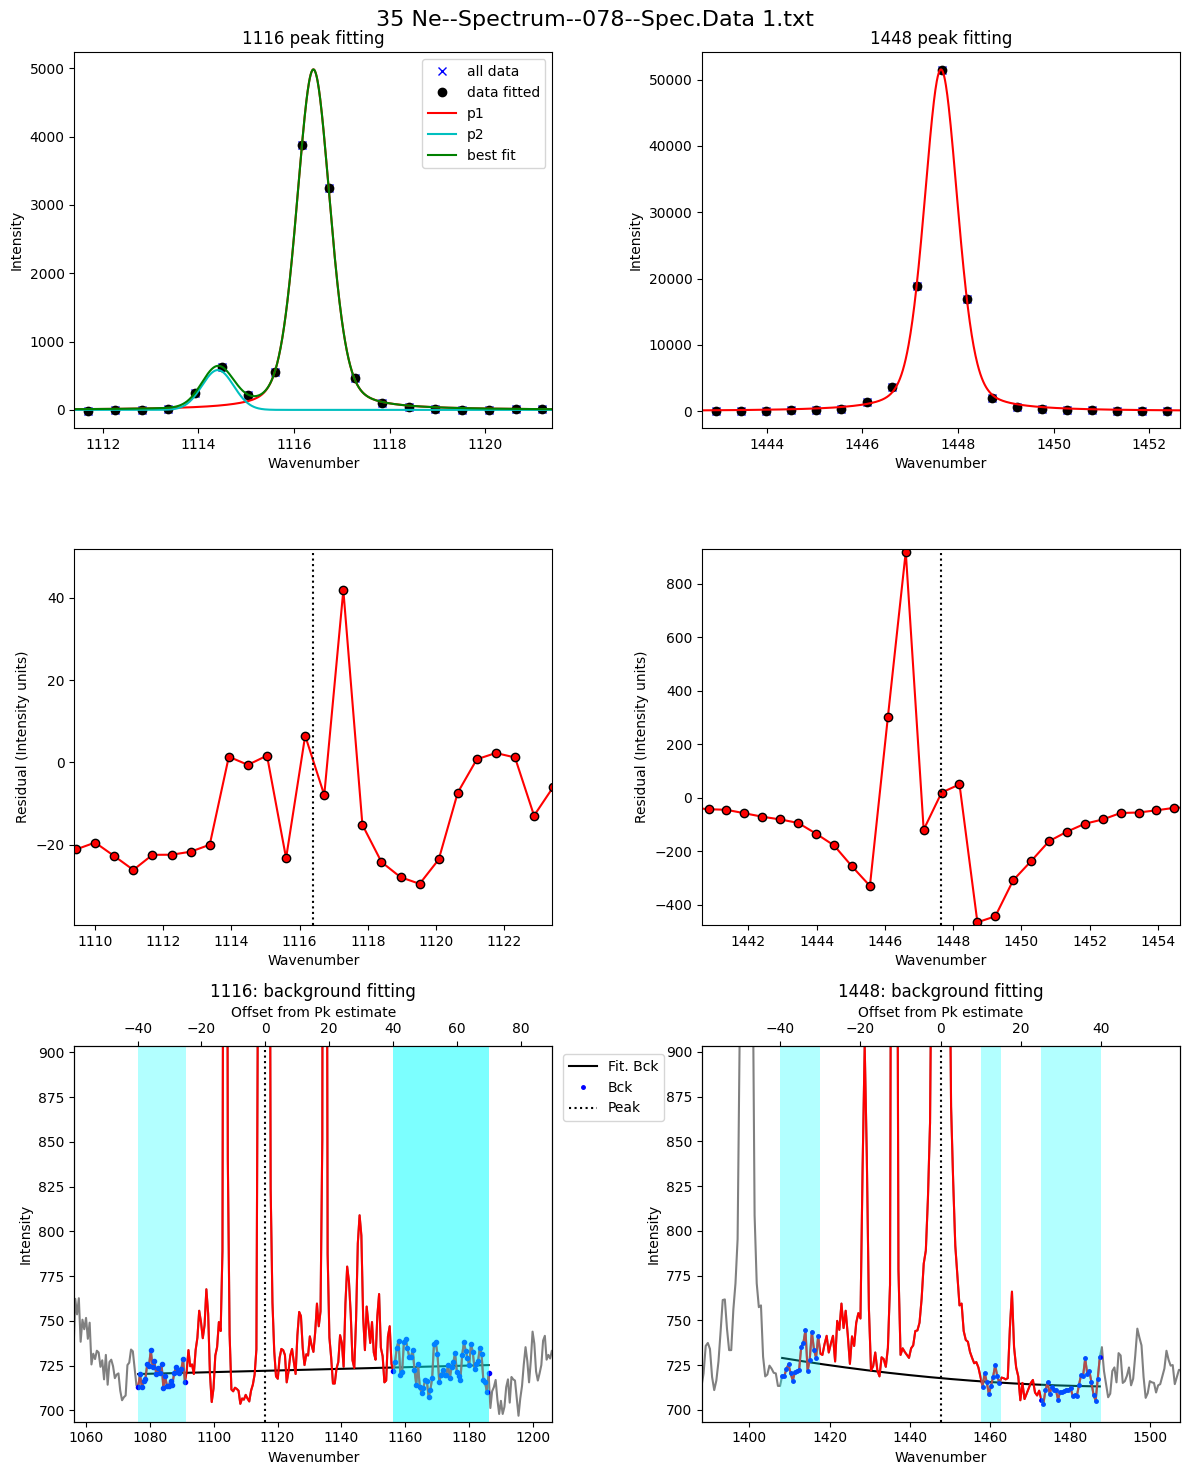

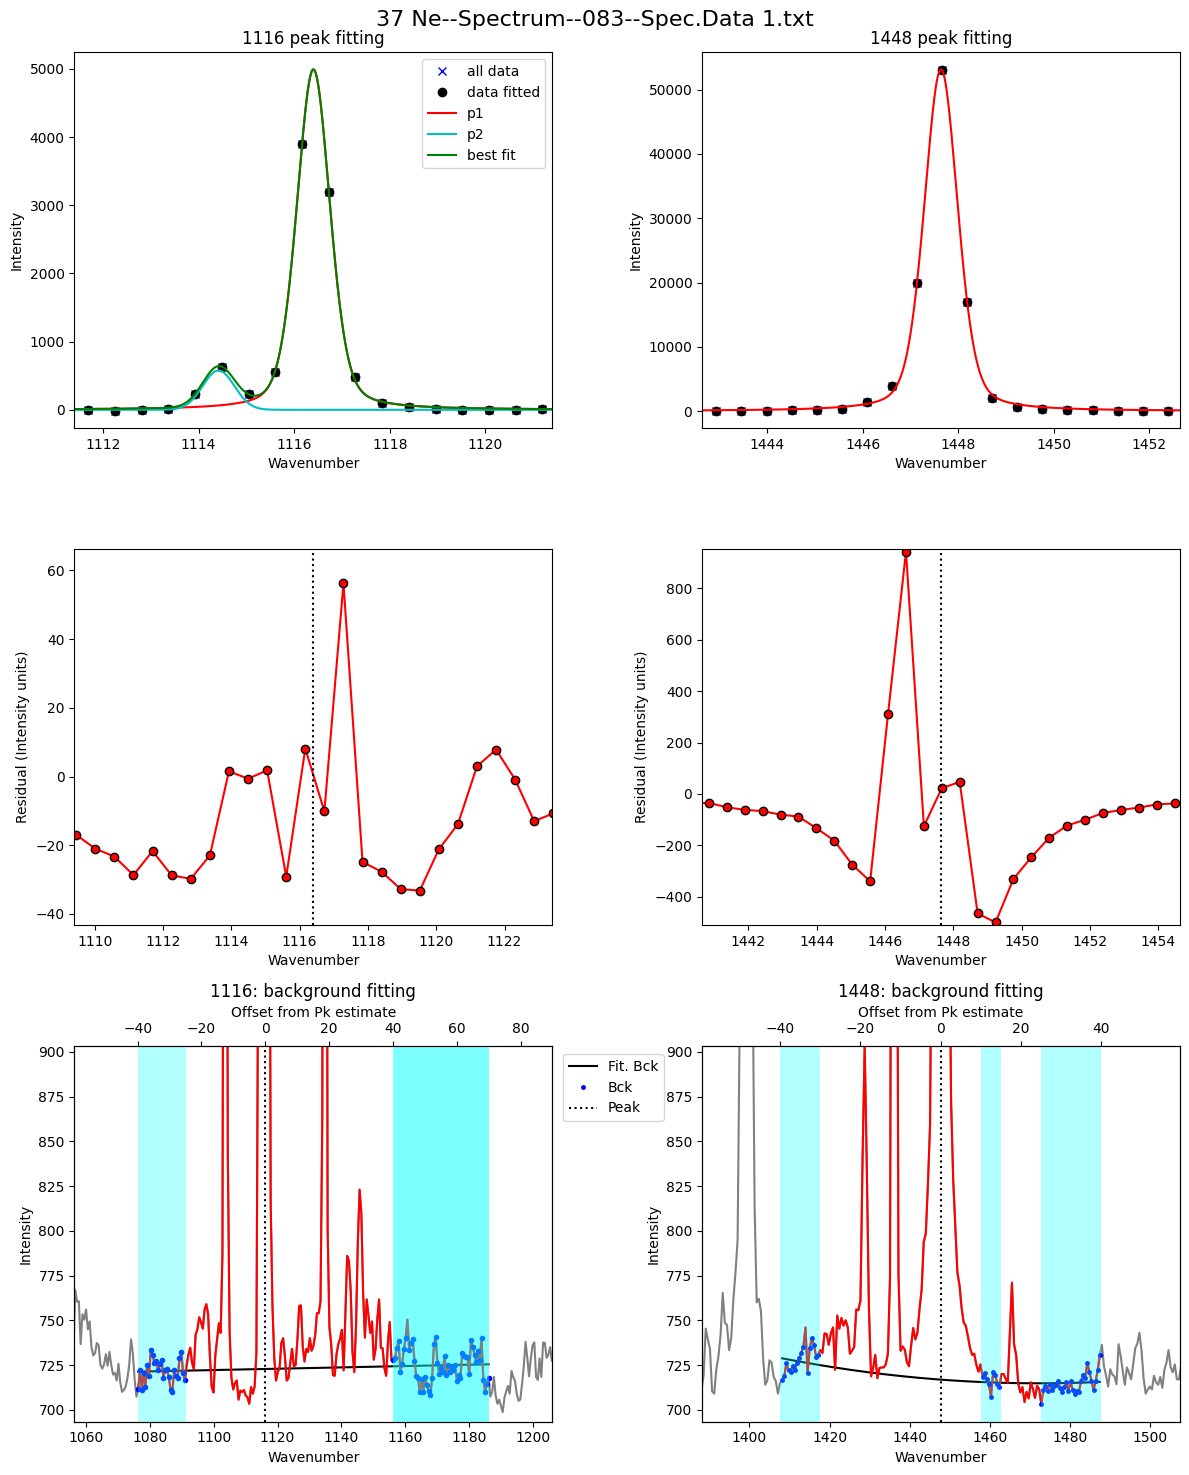

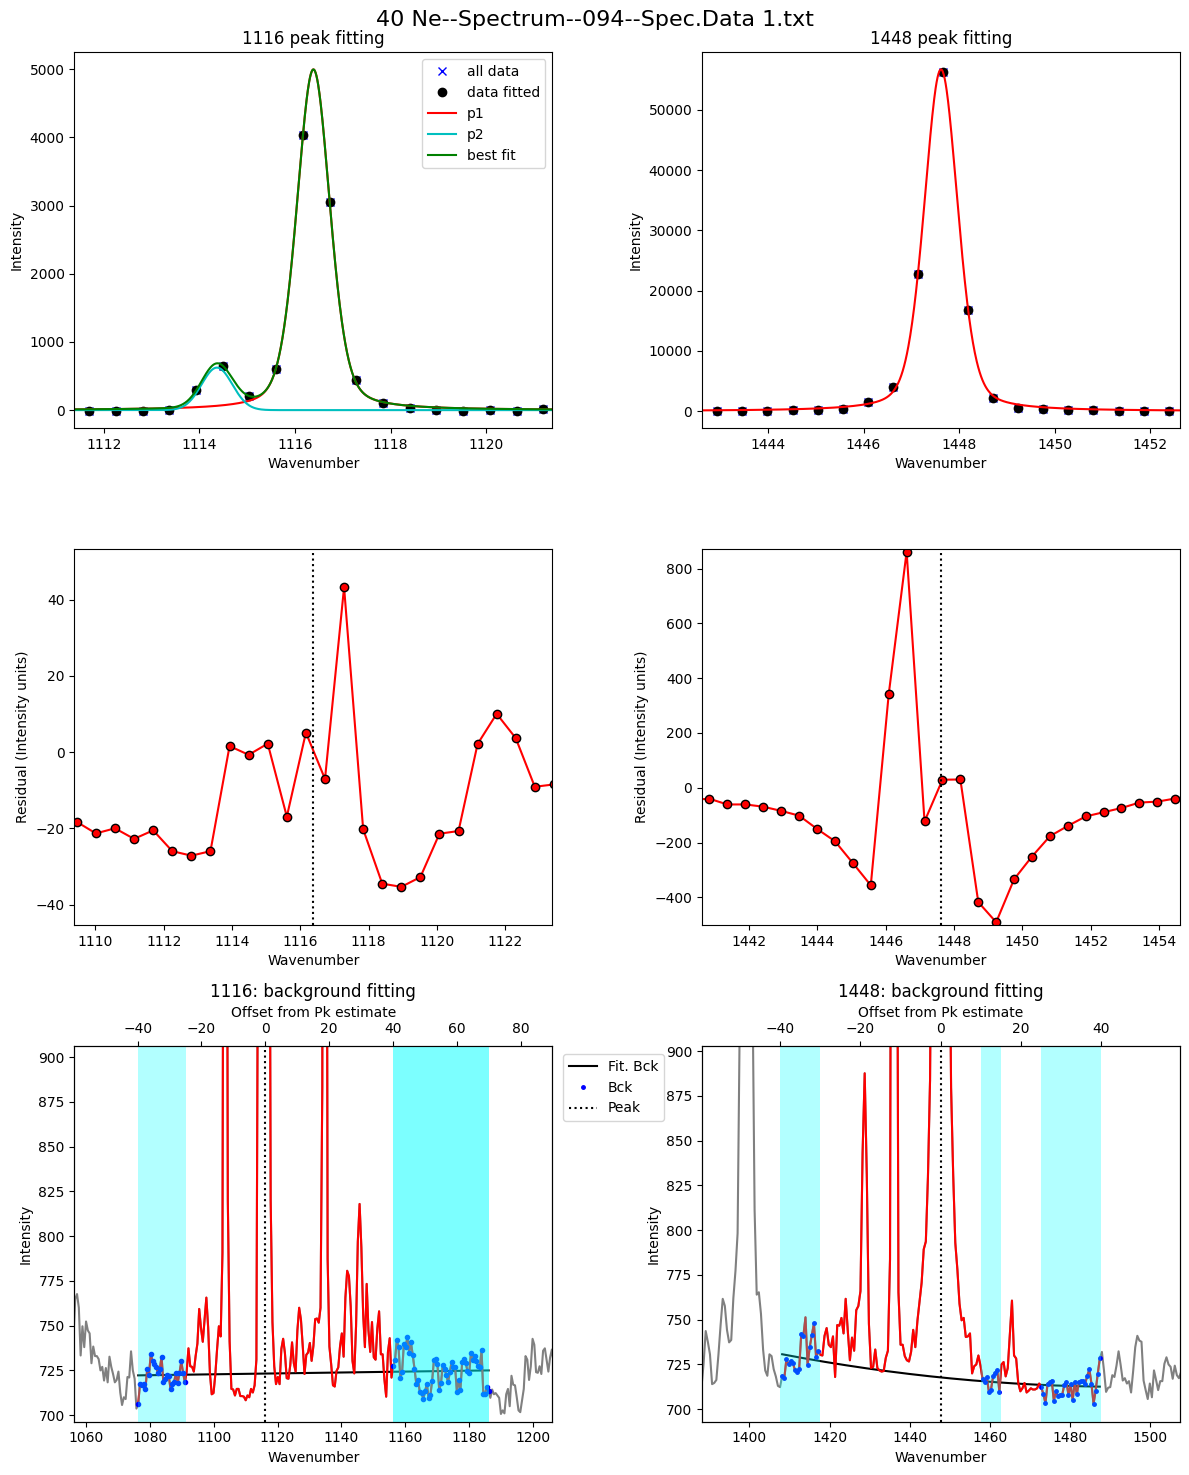

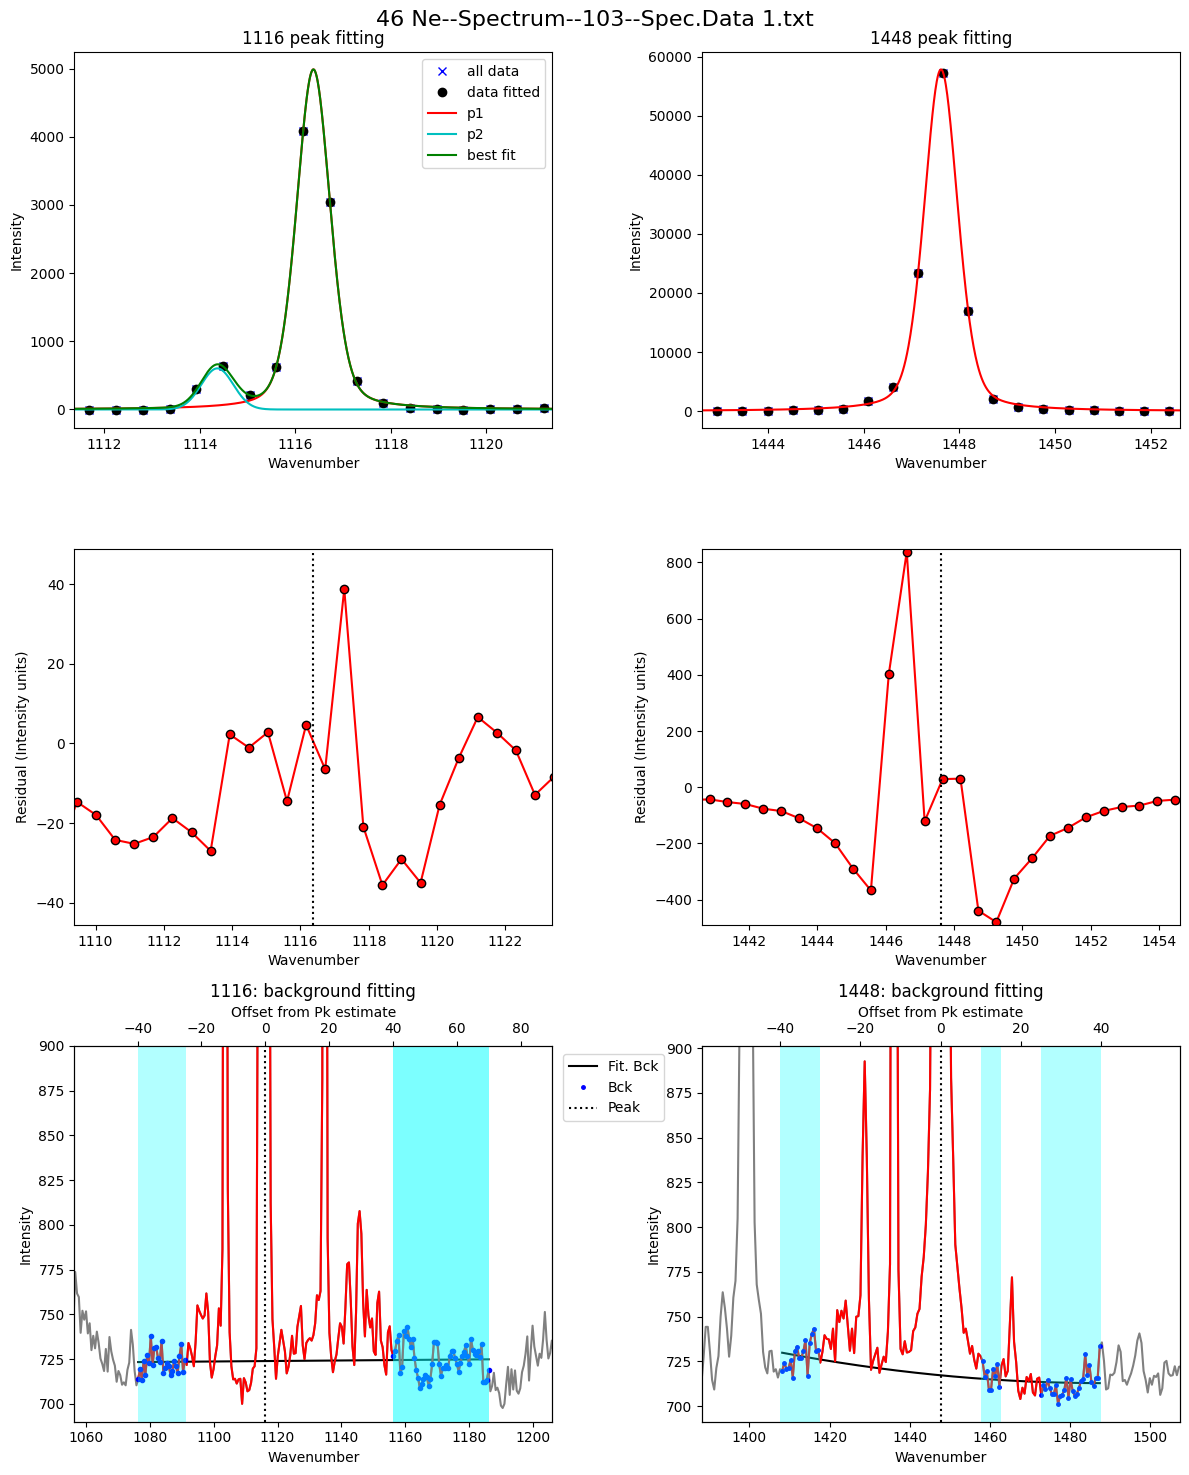

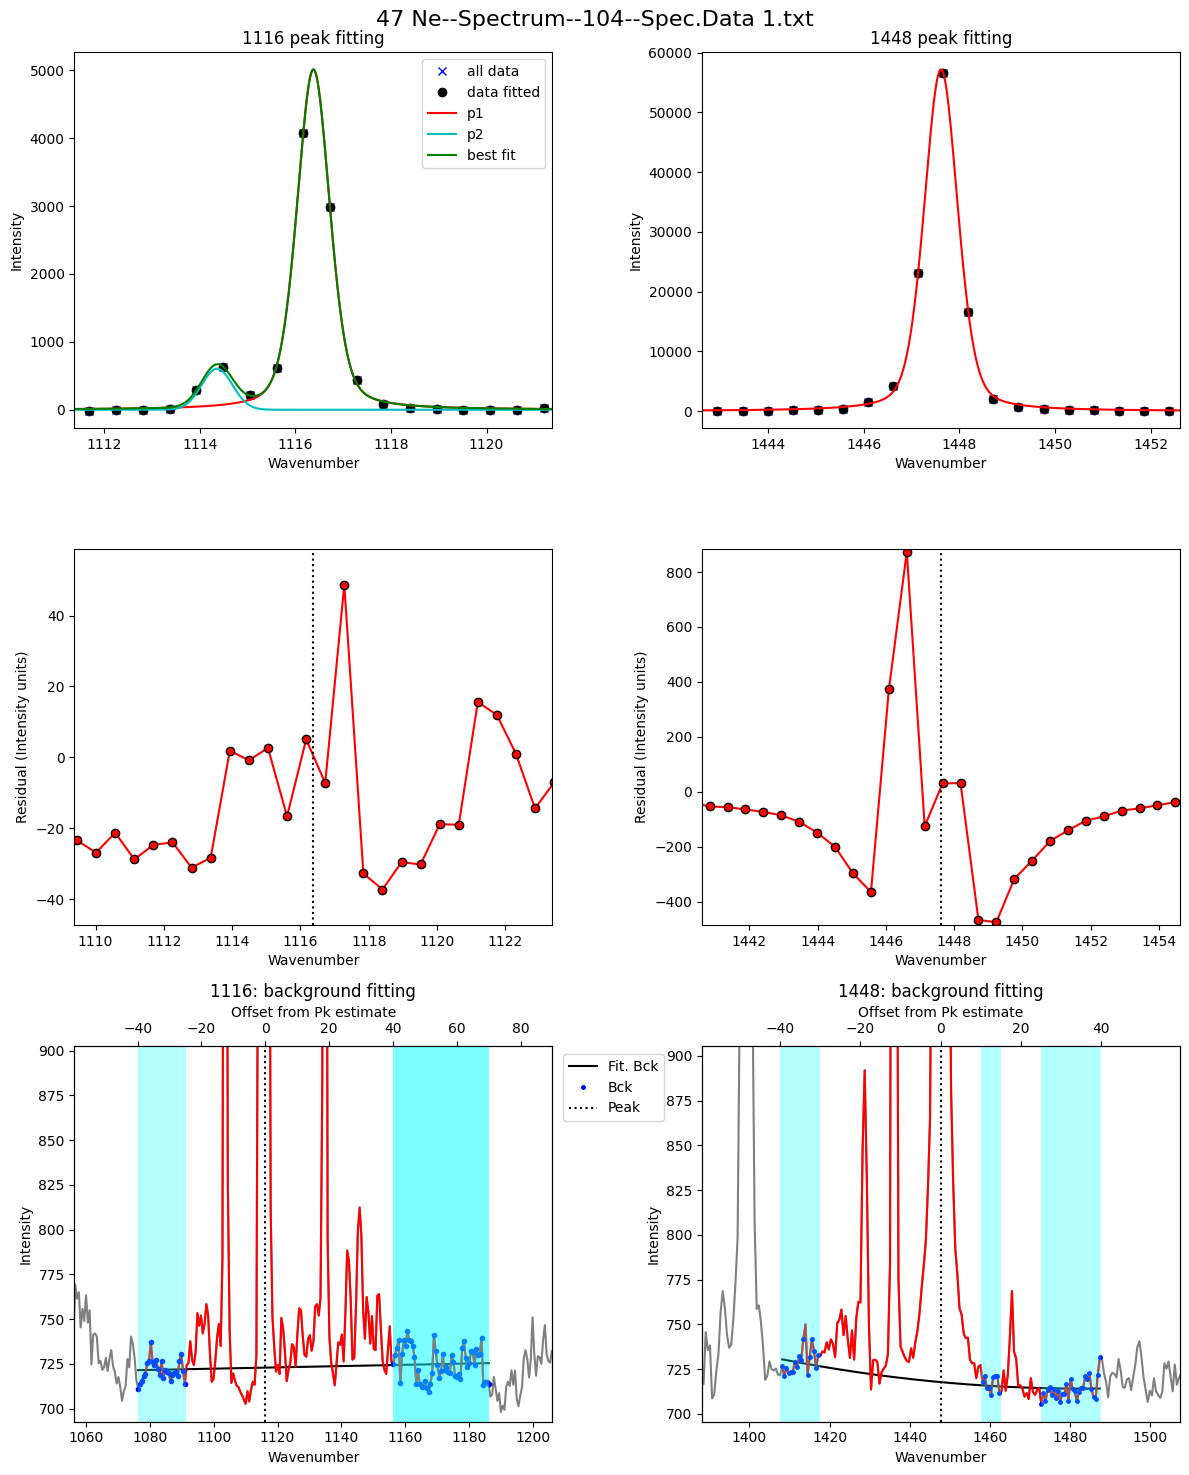

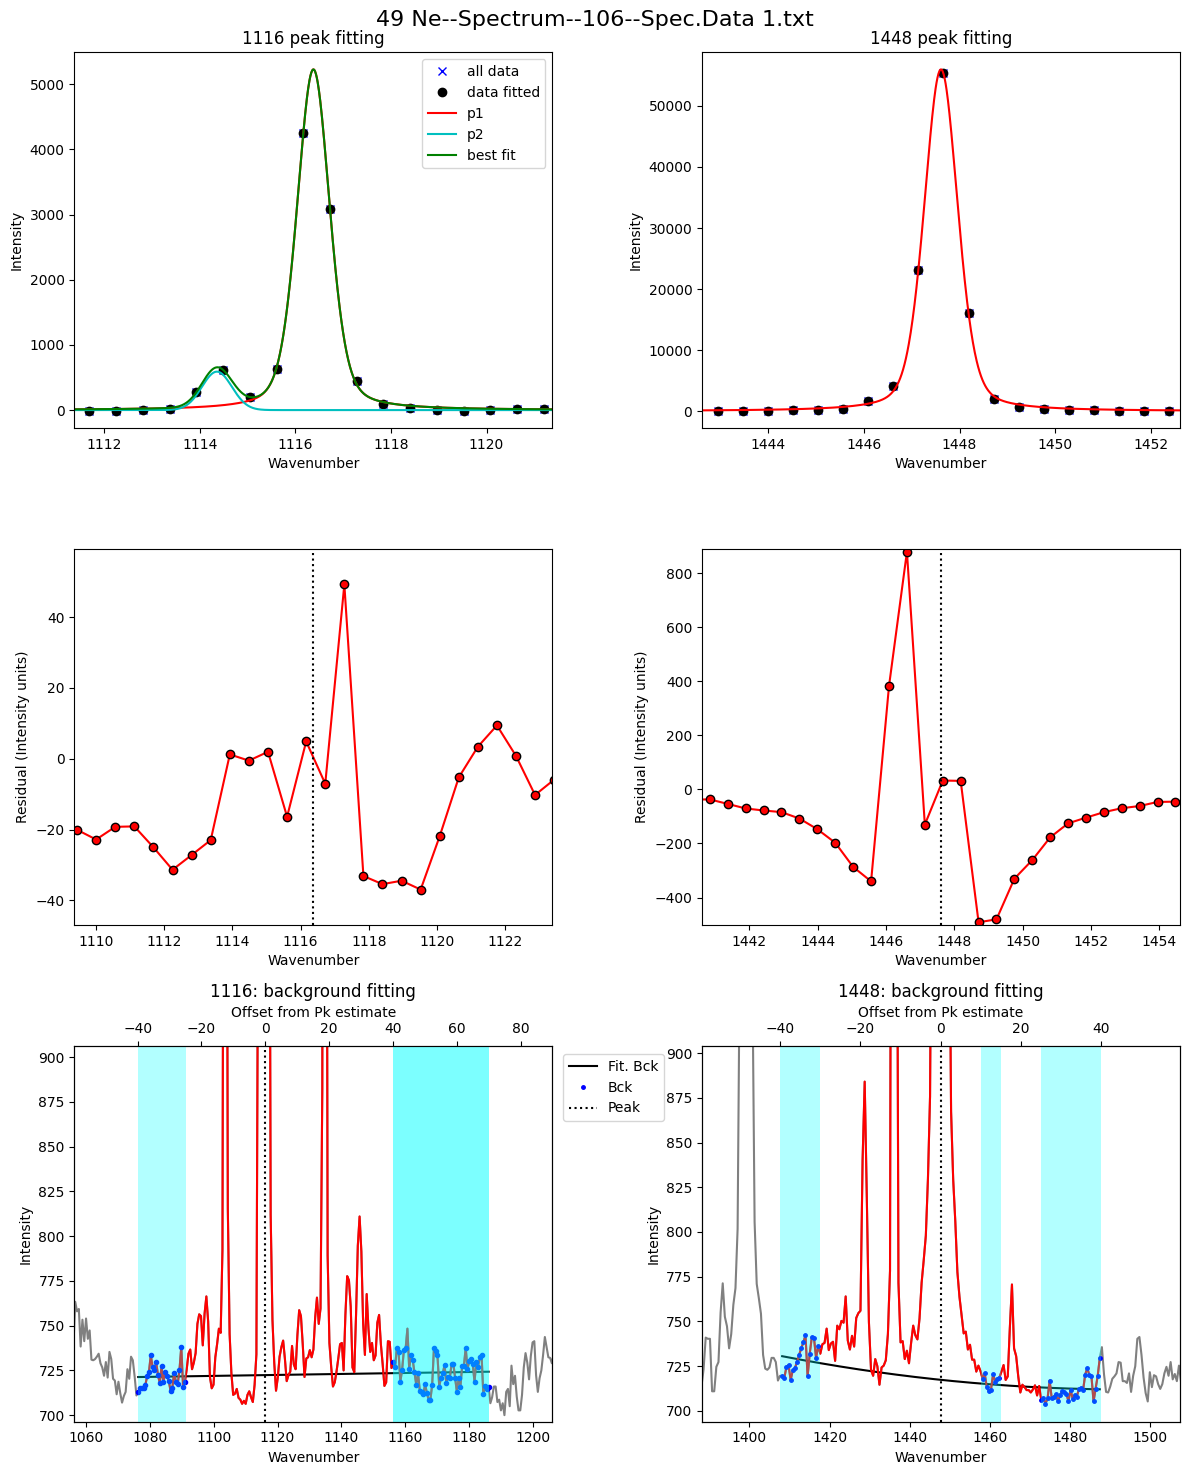

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0   Ne--Spectrum--007--Spec.Data 1.txt  0.997861    0.000039  331.186008   
1   Ne--Spectrum--008--Spec.Data 1.txt  0.997860    0.000037  331.186310   
2   Ne--Spectrum--009--Spec.Data 1.txt  0.997861    0.000038  331.186200   
3   Ne--Spectrum--014--Spec.Data 1.txt  0.997853    0.000040  331.188598   
4   Ne--Spectrum--029--Spec.Data 1.txt  0.997825    0.000042  331.197970   
5   Ne--Spectrum--044--Spec.Data 1.txt  0.997783    0.000041  331.211768   
6   Ne--Spectrum--060--Spec.Data 1.txt  0.997754    0.000038  331.221528   
7   Ne--Spectrum--070--Spec.Data 1.txt  0.997713    0.000029  331.235139   
8   Ne--Spectrum--078--Spec.Data 1.txt  0.997702    0.000031  331.238804   
9   Ne--Spectrum--083--Spec.Data 1.txt  0.997711    0.000034  331.235894   
10  Ne--Spectrum--094--Spec.Data 1.txt  0.997714    0.000037  331.234839   
11  Ne--Spectrum--103--Spec.Data 1.txt  0.997708    0.000037  331.236857   
12  Ne--Spectrum--104--Spec.Data 1.txt  0.997709    0.000039  331.236442   
13  Ne--Spectrum--106--Spec.Data 1.txt  0.997718    0.000037  331.233570   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.446335    1116.260327   56084.699152    4530.972573    117.480781   
1     1447.450739    1116.264430   57649.385787    4727.478620    125.781043   
2     1447.456775    1116.270575   57041.894934    4612.778771    127.760399   
3     1447.508165    1116.319567   31357.647587    2569.768958     77.979067   
4     1447.547285    1116.349315   56157.136238    4811.782022    136.597874   
5     1447.582074    1116.370306   54580.450933    4755.187813    138.467612   
6     1447.606718    1116.385191   53902.215094    4592.357248    137.135317   
7     1447.648029    1116.412890   54283.142339    4976.702245    138.930637   
8     1447.645944    1116.407140   52365.522610    5008.861594    131.906802   
9     1447.639323    1116.403429   53967.881593    5008.629454    135.412195   
10    1447.620363    1116.385524   57469.541927    5019.078605    137.455406   
11    1447.616998    1116.380141   58486.587291    5011.325699    139.468069   
12    1447.615294    1116.378852   57761.071990    5025.906317    140.698522   
13    1447.611478    1116.377908   56790.919924    5195.581585    140.475598   

    residual_pk1  ...  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0      12.139298  ...        0.331497   0.413414      None   0.012887   
1      12.441835  ...        0.353782   0.417260      None   0.012314   
2      13.408392  ...        0.391880   0.415551      None   0.012591   
3       8.632045  ...        0.411640   0.412007      None   0.013039   
4      14.585944  ...        0.413028   0.406719      None   0.013729   
5      15.600118  ...        0.415387   0.404612      None   0.013363   
6      14.675293  ...        0.404807   0.412253      None   0.012373   
7      14.114474  ...        0.398792   0.423638      None   0.009531   
8      15.449887  ...        0.401157   0.412365      None   0.010238   
9      17.623783  ...        0.404878   0.410141      None   0.010952   
10     16.533567  ...        0.396393   0.409683      None   0.012113   
11     15.633947  ...        0.396129   0.414132      None   0.012095   
12     18.351409  ...        0.397511   0.405739      None   0.012796   
13     17.125793  ...        0.402489   0.403287      None   0.012077   

    Peak1_Prop_Lor  Ne_Corr_min Ne_Corr_max  residual_pk1+pk2  \
0         0.338289     0.997818    0.997905        129.620079   
1         0.328112     0.997818    0.997902        138.222877   
2         0.335407     0.997818    0.997904        141.168790   
3         0.344346     0.997808    0.997899         86.611112   
4         0.395036     0.997778    0.997873        151.183818   
5         0.399801     0.997737    0.997830        154.067729   
6         0.369461     0.997711    0.997797        151.810609   
7         0.327539     0.997679    0.997747        153.045111   
8      

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['008 Ne--Spectrum--007--Information.txt',
 '009 Ne--Spectrum--008--Information.txt',
 '010 Ne--Spectrum--009--Information.txt',
 '015 Ne--Spectrum--014--Information.txt',
 '023 Ne--Spectrum--029--Information.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 14/14 [00:00<00:00, 125.74it/s]

Done


filename                date    Month   Day  \
0  Ne--Spectrum--007--Information.txt  January 18, 2024\n  January  18.0   
1  Ne--Spectrum--008--Information.txt  January 18, 2024\n  January  18.0   
2  Ne--Spectrum--009--Information.txt  January 18, 2024\n  January  18.0   
3  Ne--Spectrum--014--Information.txt  January 18, 2024\n  January  18.0   
4  Ne--Spectrum--029--Information.txt  January 18, 2024\n  January  18.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0       6.039          45.0            3.0     50.0  ['0h', '2m', '19s']   
1       6.070          45.0            3.0     50.0  ['0h', '2m', '16s']   
2       6.108          45.0            3.0     50.0  ['0h', '2m', '16s']   
3       6.043          45.0            3.0     50.0  ['0h', '2m', '16s']   
4       6.091          45.0            3.0    100.0  ['0h', '2m', '17s']   

       24hr_time  sec since midnight  Spectral Center  
0  11:30:22 AM\n             41422.0         1325.004  
1  11:33:56 AM\n             41636.0         1325.004  
2  11:38:09 AM\n             41889.0         1325.004  
3  12:17:26 PM\n             44246.0         1325.004  
4  12:53:49 PM\n             46429.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)

for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m

good job, no duplicate file names


array(['Ne--Spectrum--007', 'Ne--Spectrum--008', 'Ne--Spectrum--009',
       'Ne--Spectrum--014', 'Ne--Spectrum--029', 'Ne--Spectrum--044',
       'Ne--Spectrum--060', 'Ne--Spectrum--070', 'Ne--Spectrum--078',
       'Ne--Spectrum--083', 'Ne--Spectrum--094', 'Ne--Spectrum--103',
       'Ne--Spectrum--104', 'Ne--Spectrum--106'], dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)

for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

good job, no duplicate file names


array(['Ne--Spectrum--007', 'Ne--Spectrum--008', 'Ne--Spectrum--009',
       'Ne--Spectrum--014', 'Ne--Spectrum--029', 'Ne--Spectrum--044',
       'Ne--Spectrum--060', 'Ne--Spectrum--070', 'Ne--Spectrum--078',
       'Ne--Spectrum--083', 'Ne--Spectrum--094', 'Ne--Spectrum--103',
       'Ne--Spectrum--104', 'Ne--Spectrum--106'], dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 14, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [21]:
0.4/df_combo['error_pk2']

0     252.846826
1     247.869803
2     237.191110
3     199.525714
4     197.586640
5     208.854212
6     205.289722
7     213.519944
8     215.881159
9     219.082135
10    230.718758
11    234.865370
12    228.699100
13    221.983787
Name: error_pk2, dtype: float64

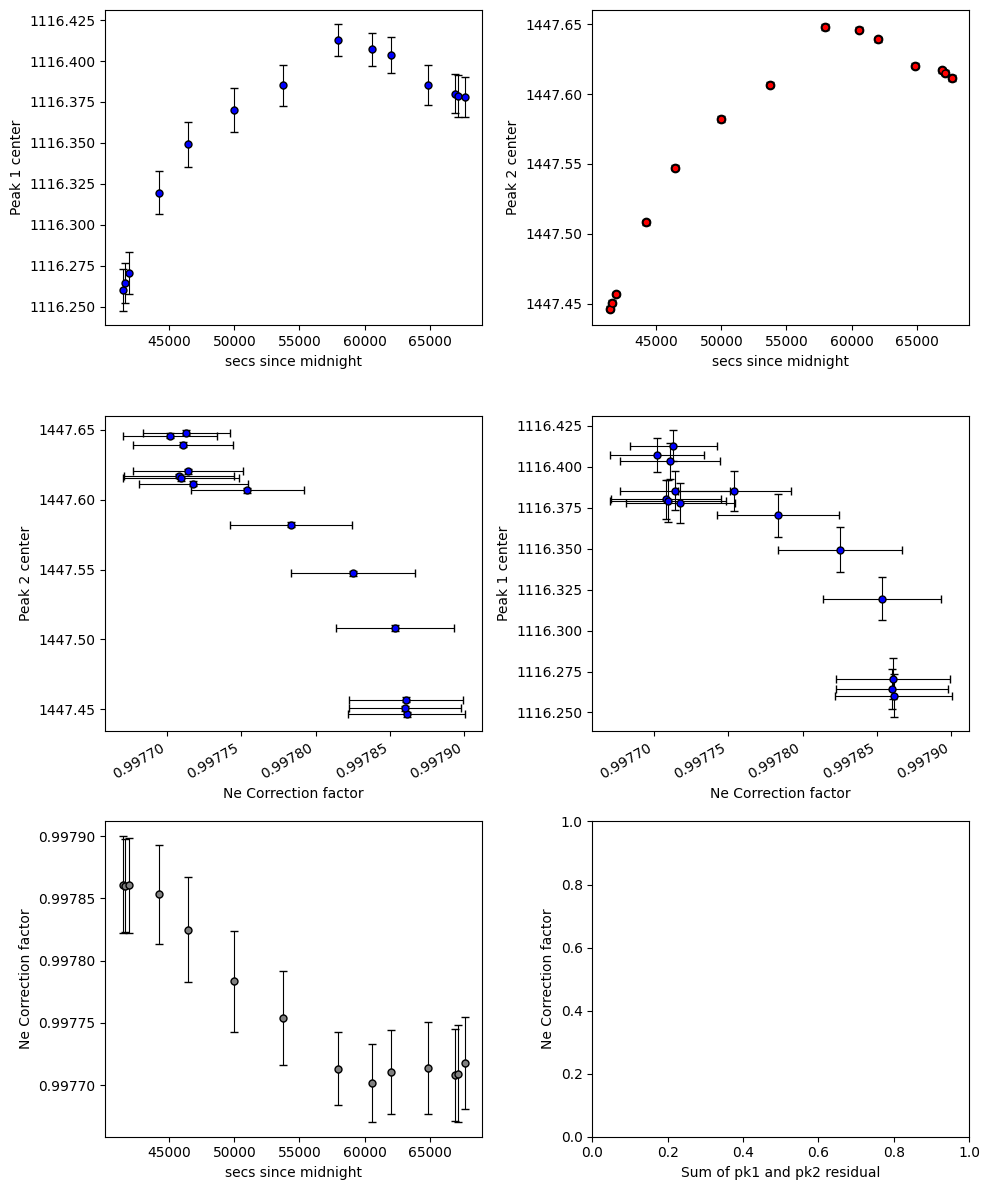

In [22]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [23]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

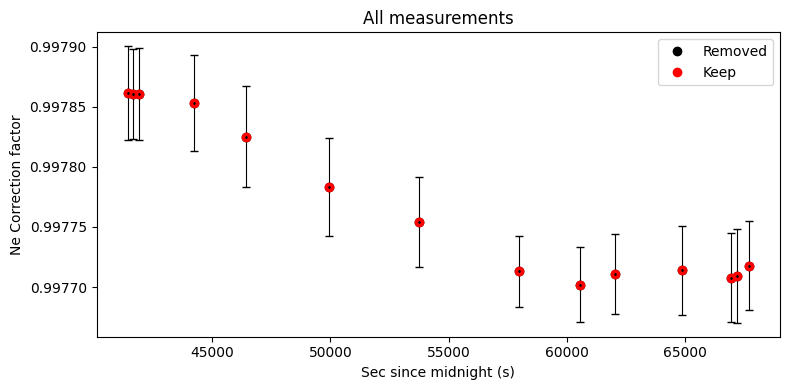

In [24]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

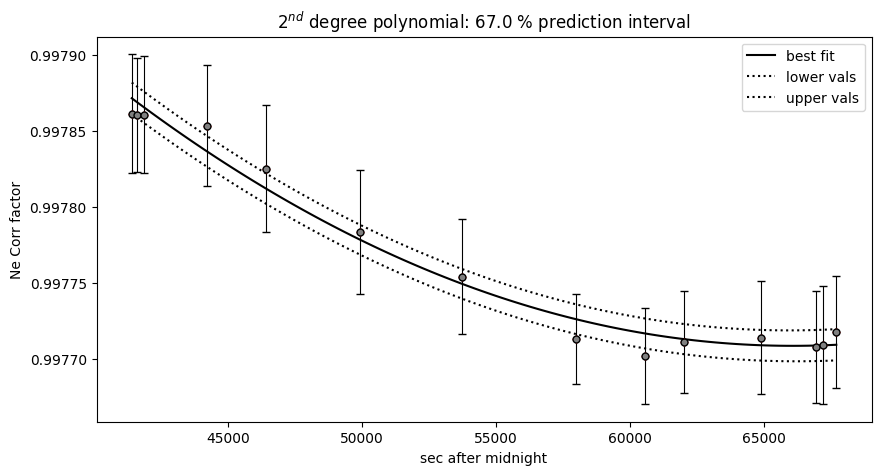

In [25]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=2, CI=0.67, pkl_name='Neon_corr_model.pkl')
